In [48]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

from SRBANDS import SRBANDS

In [49]:
period = "1mo"
interval = "1h"
symbol = "GC=F"
srbands = SRBANDS(symbol , period , interval)
df = srbands.df.copy()
df

,HIGH,LOW,CLOSE,TS,KS,SSA,SSB,UB,MB,LB,SIGNAL
Datetime,,,,,,,,,,,
2018-07-16 09:00:00,1245.30,1243.57,1243.82,1242.880,1241.435,1245.9075,1249.050,1246.6600,1242.415,1241.0950,0
2018-07-16 10:00:00,1244.05,1241.83,1242.82,1243.220,1241.310,1245.8925,1249.050,1246.0575,1242.415,1241.0950,1
2018-07-16 11:00:00,1244.39,1242.69,1243.86,1243.220,1241.310,1245.7575,1248.670,1246.0575,1242.415,1241.0950,0
2018-07-16 12:00:00,1244.90,1243.68,1244.14,1243.510,1240.925,1245.7575,1247.320,1246.0575,1242.415,1241.0950,0
2018-07-16 13:00:00,1244.26,1243.02,1244.23,1243.510,1240.925,1244.7150,1247.265,1246.0575,1242.415,1241.0950,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-11 16:00:00,1933.98,1929.44,1933.48,1933.270,1925.550,1923.4250,1918.750,1929.4100,1925.550,1914.0500,2
2023-07-11 17:00:00,1935.48,1931.17,1931.80,1933.610,1925.550,1923.6600,1918.750,1929.5800,1925.550,1914.1725,0
2023-07-11 18:00:00,1933.17,1930.22,1931.05,1933.925,1926.185,1921.6175,1918.750,1930.0550,1925.550,1914.4175,1


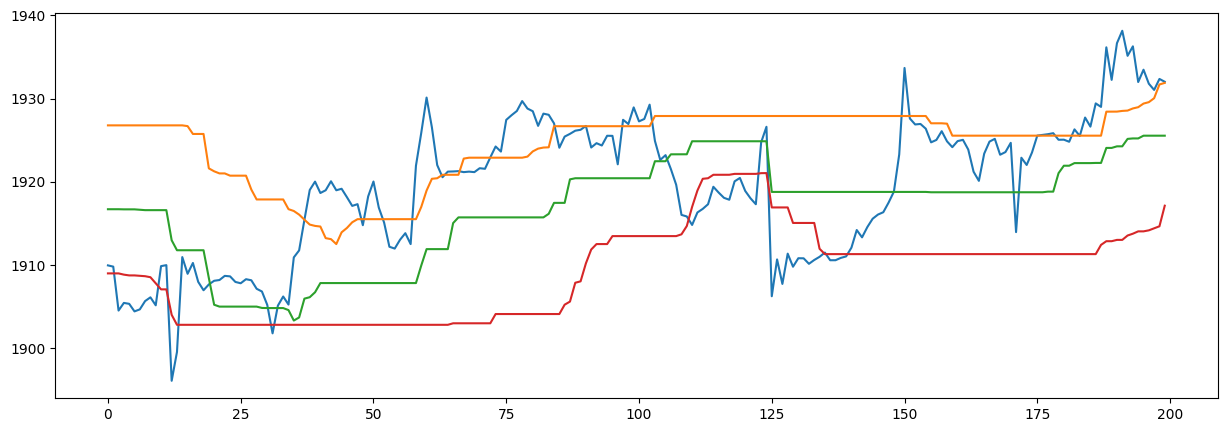

In [50]:
fig = plt.figure(figsize = (15, 5))
plt.plot(df["CLOSE"].tail(200).values)
plt.plot(df["UB"].tail(200).values)
plt.plot(df["MB"].tail(200).values)
plt.plot(df["LB"].tail(200).values)
plt.show()

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29445 entries, 2018-07-16 09:00:00 to 2023-07-11 20:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    29445 non-null  float64
 1   LOW     29445 non-null  float64
 2   CLOSE   29445 non-null  float64
 3   TS      29445 non-null  float64
 4   KS      29445 non-null  float64
 5   SSA     29445 non-null  float64
 6   SSB     29445 non-null  float64
 7   UB      29445 non-null  float64
 8   MB      29445 non-null  float64
 9   LB      29445 non-null  float64
 10  SIGNAL  29445 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 2.7 MB


In [52]:
X = df.iloc[:, : -1]
y = df.iloc[:, -1]

In [53]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (23556, 10)
Shape of y_train:  (23556,)


In [54]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = False

In [55]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [56]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [57]:
# Build First Classifier Model 0
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    # use_label_encoder=False
)

In [58]:
# Provide Gris for Hyperparams
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [59]:
# Perform Random Search for Best Hyper params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >>", f"ne: {ne},", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

c:\Users\alire\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\alire\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alire\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alire\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **sc

Recommended Params >> ne: 80, lr: 0.3 md: 5 gm: 3


In [60]:
# Build Classification Model 1
classifier_1 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

c:\Users\alire\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [61]:
# Fit Model
eval_set = [(X_train, y_train)]
classifier_1.fit(
    X_train,
    y_train,
    # eval_metric=eval_metric_list,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=3, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [62]:
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)
print("Training Preds: \n", train_yhat[:5])

Training Preds: 
 [0 1 2 1 1]


In [63]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)


In [64]:
#Training Results
train_results = cross_val_score(classifier_1, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

c:\Users\alire\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


c:\Users\alire\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\alire\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\alire\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alire\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alire\AppData\Local\Programs\Python\Pytho

In [65]:
# Brief Review of Training Results
print("Average Accuracy K-Fold: ", round(train_results.mean(), 2))
print("Std Deviation K-Fold: ", round(train_results.std(), 2))
print("Precision Score 0: ", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1: ", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("")
print("Just for reference. Right now, we are only focussed on getting some initial features.")
print("If the results look too good to be true, they probably are.")

Average Accuracy K-Fold:  nan
Std Deviation K-Fold:  nan
Precision Score 0:  0.523
Precision Score 1:  0.507

Just for reference. Right now, we are only focussed on getting some initial features.
If the results look too good to be true, they probably are.


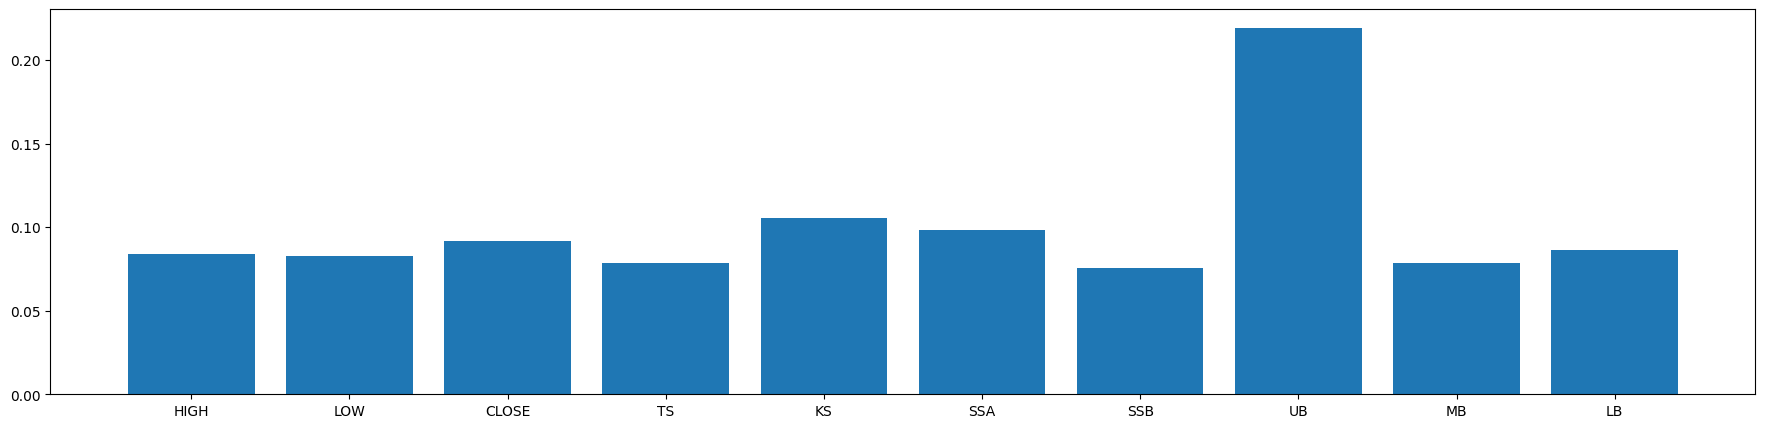

In [66]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [67]:
# Select Best Features
mean_feature_importance = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

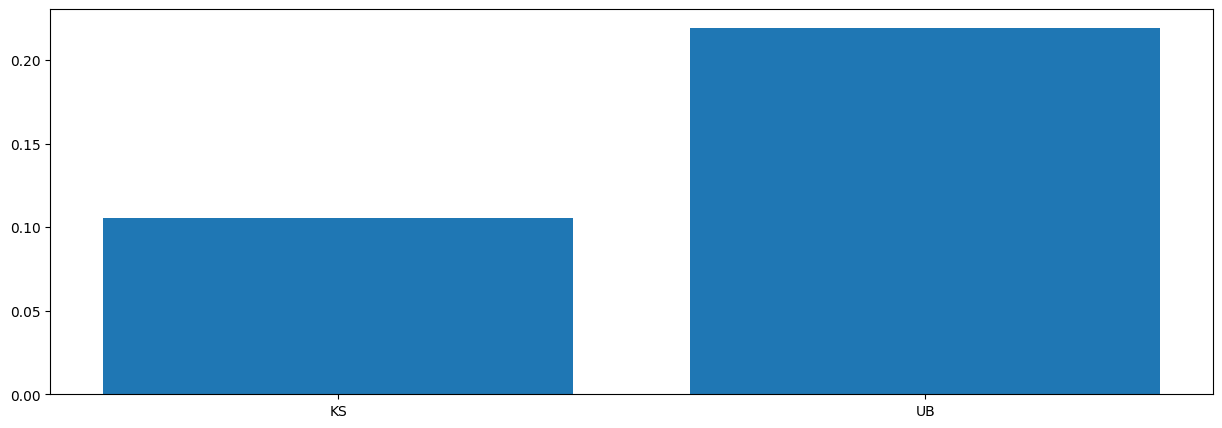

In [68]:
# Plot Recommended Features
fig = plt.figure(figsize=(15, 5))
plt.bar(recommended_feature_labels, recommended_feature_score)
plt.show()